<a href="https://colab.research.google.com/github/my612/Quantamania/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Traveling Salesman Problem (TSP) Optimization

# 1. From Integer Linear Programming (ILP) to Quadratic Unconstrained Binary Optimization (QUBO)

## 1.1 ILP Problem Definition

### Problem Description

The Traveling Salesman Problem (TSP) is a classic optimization problem where the goal is to find the shortest possible route that visits each city exactly once and returns to the origin city. Given a set of cities and the distances between each pair of cities, the objective is to determine the optimal tour with the minimum total travel distance.

### MTZ Formulation

The Miller-Tucker-Zemlin (MTZ) formulation is a well-known Integer Linear Programming (ILP) approach to solve the TSP. It introduces additional variables to prevent subtours, ensuring a single contiguous tour.

### Variables

- $( x_{ij} )$: Binary variable indicating whether the path goes directly from city $( i )$ to city $( j )$.
- $( u_i )$: Auxiliary variable representing the order or rank of city $( i $) in the tour.

### Objective Function

Minimize the total travel distance:
$$
\text{minimize} \quad \sum_{i=1}^{n} \sum_{j=1}^{n} d_{ij} x_{ij}
$$
where $( d_{ij} )$ is the distance from city $( i $) to city $( j $).

### Constraints

1. **Outgoing arcs:**
   $$
   \sum_{j=1, j \neq i}^{n} x_{ij} = 1 \quad \forall i = 1, 2, \dots, n
   $$
2. **Incoming arcs:**
   $$
   \sum_{i=1, i \neq j}^{n} x_{ij} = 1 \quad \forall j = 1, 2, \dots, n
   $$
3. **Subtour elimination:**
   $$
   u_i - u_j + n x_{ij} \leq n - 1 \quad \forall i, j = 2, 3, \dots, n; i \neq j
   $$
4. **Variable bounds:**
   $$
   x_{ij} \in \{0, 1\} \quad \forall i, j = 1, 2, \dots, n; i \neq j
   $$
   $$
   u_i \in \mathbb{Z} \quad \forall i = 1, 2, \dots, n
   $$

### Assumptions

- Symmetric TSP: $( d_{ij} = d_{ji} $) for all $( i, j $).
- No self-loops: $( d_{ii} = 0 $) for all $( i $).

### Explanation

The MTZ formulation uses the auxiliary variables $( u_i $) to prevent subtours by enforcing an ordering on the cities. This ensures that the solution forms a single tour rather than multiple disconnected subtours.

This formulation is effective for solving the TSP and is widely used due to its simplicity and computational efficiency for moderate-sized instances.

## 1.2 Fromulating the problem using Qiskit's QuadraticProgram




In [ ]:
!pip install qiskit_optimization qiskit_algorithms
!pip install dimod
!pip install dwave-ocean-sdk

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo

In [ ]:
def TSP_as_ILP(dist_matrix, print_model = False):


  mod = QuadraticProgram("TSP")

  num_cities = len(dist_matrix)

  for i in range(num_cities):
      for j in range(num_cities):
          if i != j:
              mod.binary_var(f"x_{i}_{j}")
  for i in range(num_cities):
      mod.linear_constraint(linear={f"x_{i}_{j}": 1 for j in range(num_cities) if i != j}, sense='==', rhs=1, name=f'out_{i}')
      mod.linear_constraint(linear  ={f"x_{j}_{i}": 1 for j in range(num_cities) if i != j}, sense='==', rhs=1, name=f'in_{i}')
  t = {}
  for i in range(num_cities):
      t[i] = mod.integer_var(lowerbound=0, upperbound=num_cities-1, name=f't_{i}')
  for i in range(1, num_cities):  # t_0 is fixed to 0, so start from i=1
      for j in range(1, num_cities):  # Ensure i != j
          if i != j:
              mod.linear_constraint(
                  linear={f"t_{j}": 1, f"t_{i}": -1, f"x_{i}_{j}": -(num_cities - 1)},
                  sense='>=',
                  rhs=1 - (num_cities - 1),
                  name=f"subtour_{i}_{j}"
              )
  obj = {}
  for i in range(num_cities):
    for j in range(num_cities):
        if i != j:
            obj[f"x_{i}_{j}"] = dist_matrix[i][j]
  mod.minimize(linear=obj)
  print(mod.prettyprint())
  return mod


## 1.3 Conversion from ILP to QUBO


In [ ]:
def convert_ILP_to_QUBO(model, print_model = False):
    qubo = QuadraticProgramToQubo().convert(model)

    if print_model:
        print(qubo.prettyprint())

    return qubo

## 1.4 Using a specific instance of the problem.


In [ ]:

dist_matrix = [
    [0, 2, 9,],
    [2, 0, 6,],
    [9, 6, 0,]
]

model = TSP_as_ILP(dist_matrix, print_model=True)

qubo = convert_ILP_to_QUBO(model, print_model=True)

# 2. Classical PuLP Solver for **TSP**

### 2.1 Implementing the TSP solver using PuLP

Install PuLP to solve the problem using integer linear programming,
and import the required libraries.

In [3]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 51.0 MB/s eta 0:00:00


In [12]:
from pulp import *
import math
from random import randrange
import matplotlib.pyplot as plt
from itertools import pairwise, permutations
from time import perf_counter

Here we define a function to generate the ILP model for the problem given a distance matrix for the nodes, using the MTZ formulation shown previously.

In [5]:
def create_model(dists):
    """MTZ formulation for TSP"""
    n = len(dists)
    tsp = LpProblem("TSP", LpMinimize)
    # x_ij denotes if there is directed edge from node i to node j
    x = LpVariable.dicts('x', [(i, j) for i in range(n) for j in range(n)], cat=LpBinary)
    # u_i represents the order/rank of node i
    u = LpVariable.dicts('u', range(n), 1, n, LpContinuous)

    # add the objective function
    tsp += lpSum(dists[i][j] * x[(i, j)] for i in range(n) for j in range(n))

    # add the constraints
    for i in range(n):
        tsp += x[(i, i)] == 0 # no loops
        tsp += lpSum(x[(i, j)] for j in range(n)) == 1 # outdegree == 1
        tsp += lpSum(x[(j, i)] for j in range(n)) == 1 # indegree == 1

    for i in range(n):
        for j in range(n):
            if i != j and i != 0 and j != 0:
                tsp += u[i] - u[j] + n*x[(i, j)] <= n - 1 # subtour elimination

    return tsp, x, u

Create some implementations to solve the TSP using brute force and backtracking techniques.

In [6]:
def brute_force(dists):
    """Iterates over all possible routes to find the minimum. O(n!)"""
    n = len(dists)
    min_dist = math.inf
    min_route = None
    for route in permutations(range(1, n)):
        dist = 0
        u = 0
        for v in route:
            dist += dists[u][v]
            u = v
        dist += dists[u][0]
        if dist < min_dist:
            min_dist = dist
            min_route = route
    return min_dist, list(pairwise([0] + list(min_route) + [0]))

def _backtracking(dists, u, dist, route, min_dist, min_route):
    """
    Backtracking implementation.
    Also O(n!), but should be faster than the naive implementation.
    """
    if dist >= min_dist[0]:
        # if the current distance is not lower than the minimum
        # we have found so far, don't explore this route further.
        return

    n = len(dists)
    if len(route) == n:
        dist += dists[u][0]
        if dist < min_dist[0]:
            min_dist[0] = dist
            min_route[:] = route + [0]
        return

    for v in range(n):
        if v == u or v in route:
            continue
        route.append(v)
        _backtracking(dists, v, dist + dists[u][v], route, min_dist, min_route)
        route.pop()
    return
def backtracking(dists):
    dist, route = [math.inf], [] # hack for pass by reference in python
    _backtracking(dists, 0, 0, [0], dist, route)
    return dist, list(pairwise(route))

Here we define functions to generate a sample distance matrix for the problem.

In [7]:
def distance(a, b):
    """Calculates the Euclidean distance between two points."""
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def generate_data(n):
    """Generates a random set of n points and the distances between them."""
    coords = [(randrange(100), randrange(100)) for _ in range(n)]
    dists = [[0] * n for _ in range(n)]
    for i in range(n):
        for j in range(i + 1, n):
            dists[i][j] = dists[j][i] = distance(coords[i], coords[j])
    return dists, coords

Generate a distance matrix with $n$ nodes, and create a function to plot the route we find.

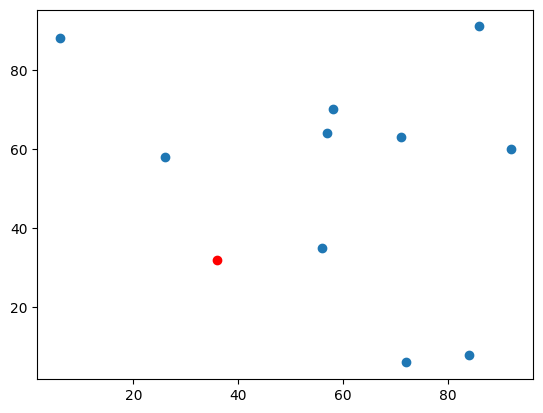

In [ ]:
n = 10
dists, coords = generate_data(n)

# plot the points
plt.plot(coords[0][0], coords[0][1], 'ro')
plt.plot([p[0] for p in coords[1:]], [p[1] for p in coords[1:]], 'o')
plt.show()

def plot_route(route):
    plt.plot(coords[0][0], coords[0][1], 'ro')
    for u, v in route:
        plt.plot([coords[u][0], coords[v][0]], [coords[u][1], coords[v][1]], 'b')


Create and solve the ILP model, and plot the solution.

Optimal 320.5201033639212
[(0, 5), (1, 6), (2, 4), (3, 7), (4, 8), (5, 2), (6, 0), (7, 1), (8, 9), (9, 10), (10, 3)]


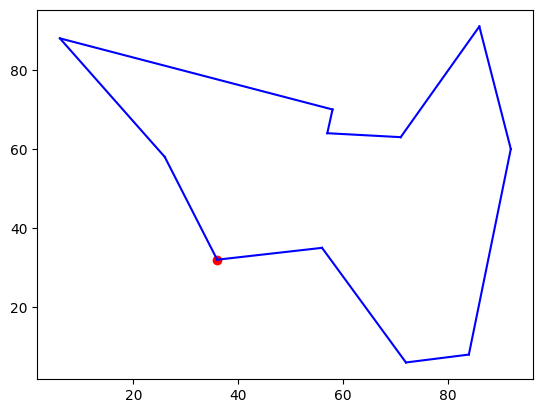

In [ ]:
model, x, _ = create_model(dists)
status = model.solve()
print(LpStatus[status], pulp.value(model.objective))
route = [(i, j) for i in range(n) for j in range(n) if pulp.value(x[(i, j)]) == 1]
print(route)
plot_route(route)

Solve the problem using other techniques.

[320.5201033639212]
[(0, 6), (6, 1), (1, 7), (7, 3), (3, 10), (10, 9), (9, 8), (8, 4), (4, 2), (2, 5), (5, 0)]


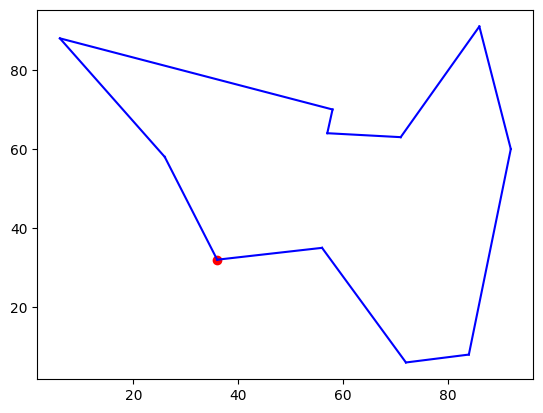

In [ ]:
dist, route = backtracking(dists)
print(dist)
print(route)
plot_route(route)

320.5201033639212
[(0, 6), (6, 1), (1, 7), (7, 3), (3, 10), (10, 9), (9, 8), (8, 4), (4, 2), (2, 5), (5, 0)]


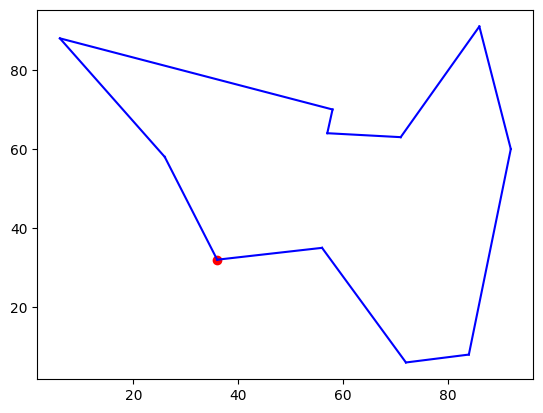

In [ ]:
dist, route = brute_force(dists)
print(dist)
print(route)
plot_route(route)

We can see that the ILP solution is optimal because it matches that of the brute force implementation.

### 2.2 Analysis of Results

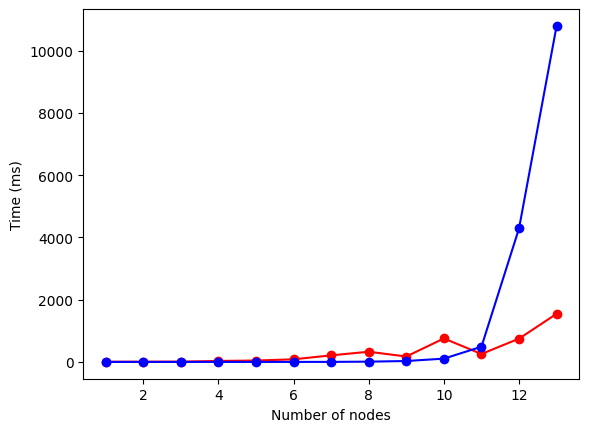

In [33]:
samples = 3
N = 14
sizes = range(1, N)
problems = [(n, [generate_data(n)[0] for _ in range(samples)]) for n in sizes]

ilp_times = []
for n, dists in problems:
    total_time  = 0
    for dist in dists:
        start = perf_counter()
        model, x, _ = create_model(dist)
        status = model.solve()
        total_time += perf_counter() - start
    ilp_times.append(total_time / samples)

backtracking_times = []
for n, dists in problems:
    total_time  = 0
    for dist in dists:
        start = perf_counter()
        backtracking(dist)
        total_time += perf_counter() - start
    backtracking_times.append(total_time / samples)



plt.plot(sizes, [(1e3)*t for t in ilp_times], '-ro')
plt.plot(sizes, [(1e3)*t for t in backtracking_times], '-bo')
plt.xlabel("Number of nodes")
plt.ylabel("Time (ms)")
plt.show()

# 3. Brute Force Solver for QUBO Formulation

### 3.1 Brute Force Solution Approach


### 3.2 Implementation and Testing


# 4. Quantum Annealing Simulators to solve the QUBO

#### 4.1 Setting up the Quantum Annealing Simulator

#### 4.2 Solving TSP Instances


#### 4.3 Analysis of Quantum Annealing Results

# 5. Comparative Analysis and Conclusion

#### 5.1 Comparative Performance Analysis


#### 5.2 Conclusion
